# Activity time series and Granger Causality Analysis

In [2]:
import pandas as pd
import datetime as dt

from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests

## 1 - Activity time series of MPs and journalists

In [4]:
from analysis_labels import *

In [48]:
import matplotlib as mpl
mpl.rc('font',family='Arial')

In [5]:
path_data = "../data/"

df_journalists = pd.read_csv(path_data+"Labelled_Journalist_Tweets.csv")
df_mps = pd.read_csv("Labelled_MP_Tweets.csv")

/var/folders/98/psf1_y4d0lq7cldjh1wb_68r0000gr/T/ipykernel_29411/3724322033.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_journalists = pd.read_csv('Labelled_Journalist_Tweets.csv')
/var/folders/98/psf1_y4d0lq7cldjh1wb_68r0000gr/T/ipykernel_29411/3724322033.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mps = pd.read_csv('Labelled_MP_Tweets.csv')


In [6]:
format_date = '%d/%m/%y'
TOTAL = 7

In [8]:
dates_journalists = [date for date in df_journalists.date.unique()][:-2]
dates_mps = [date for date in df_mps.date.unique()][:-2]

dates = list(np.unique(np.array(dates_journalists+dates_mps)))

In [9]:
change_to_dt = lambda x: dt.datetime.strptime(x, format_date)

In [10]:
dates_dt = [change_to_dt(date) for date in dates]

dates_dt.sort()

dates_str = [dt.datetime.strftime(date, format_date) for date in dates_dt]

In [13]:
tweets_per_day_journalists = get_labels_per_day(dates_str, df_journalists, TOTAL, False)
tweets_per_day_mps = get_labels_per_day(dates_str, df_mps, TOTAL, False)

In [14]:
topics = [1, 3, 5, 6]

# 1 - Ukraine
# 3 - COVID
# 5 - Cost of Living Crisis
# 6 - Brexit

In [17]:
def get_topic(topic):
    if topic == 1:
        return 'Ukraine'
    elif topic == 3:
        return 'COVID'
    elif topic == 5:
        return 'Cost of Living Crisis'
    elif topic == 6:
        return 'Brexit'
    else:
        return 'other topic'
    

In [51]:
def plot_topic_delta(topic, delta_t, ymax):
    ### dates
    new_dates = cluster_dates(delta_t, dates_str, format_date=format_date)

    new_dates_str = [dt.datetime.strftime(date, format_date) for date in new_dates]

    clustered_tweets_mps = cluster_labels(dates_str, new_dates, tweets_per_day_mps, 
                                          format_date=format_date, normalization=False)
    clustered_tweets_journalists = cluster_labels(dates_str, new_dates, tweets_per_day_journalists, 
                                          format_date=format_date, normalization=False)


    ### plot
    font = {"fontname": "Arial"}
    alpha=0.8
    figsize=(10, 6)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    palette = sns.color_palette("viridis")
    
    plt.plot(clustered_tweets_mps[:, topic].T, color=palette[0], alpha=alpha, label='mps')
    plt.plot(clustered_tweets_journalists[:, topic].T, color=palette[-1], alpha=alpha, label='journalists')

    ax.set_yscale('log')
    plt.grid()

    plt.xlabel('Time (day)', size='xx-large', **font)
    plt.ylabel('Tweets', size='xx-large', **font)

    plt.xticks(size='xx-large')
    plt.yticks(size='xx-large')

    plt.ylim(1, ymax)
    

    plt.title(get_topic(topic), size='xx-large', **font)

    plt.legend(fontsize='x-large')

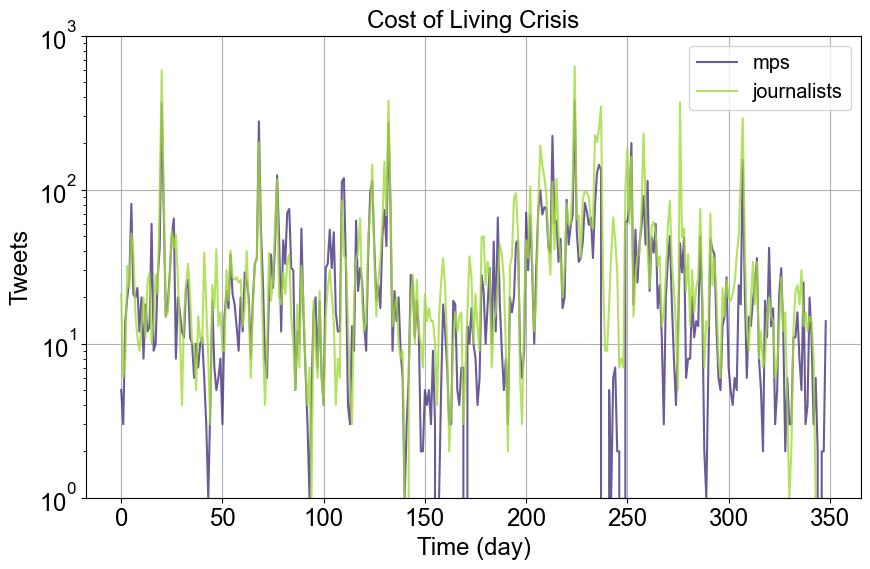

In [53]:
### topics:
# 1 - Ukraine; 3 - COVID; 5 - Cost of Living Crisis; 6 - Brexit
topic = 5
delta_t = 1

ymaxs = [10000, 10000, 10000, 1000, 10000, 1000, 1000]

plot_topic_delta(topic, delta_t, ymaxs[topic])

plt.savefig(f'activity_{topic}.png', format='png', dpi=500, transparent=True)

## 2 - Granger causality

In [28]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

def log_array(array):
    array[array==0] = 1
    return np.log(array)

def make_df_granger(array_journalists, array_mps):
    return pd.DataFrame({'journalists': array_journalists,
                         'mps': array_mps})

In [35]:
topic = 5
delta_t = 1
maxlag = 7

### dates
new_dates = cluster_dates(delta_t, dates_str, format_date=format_date)

new_dates_str = [dt.datetime.strftime(date, format_date) for date in new_dates]

clustered_tweets_mps = cluster_labels(dates_str, new_dates, tweets_per_day_mps, 
                                      format_date=format_date, normalization=False)
clustered_tweets_journalists = cluster_labels(dates_str, new_dates, tweets_per_day_journalists, 
                                      format_date=format_date, normalization=False)

log_journalists = log_array(clustered_tweets_journalists[:, topic])
log_mps = log_array(clustered_tweets_mps[:, topic])

df_granger = make_df_granger(log_journalists, log_mps)

#results = grangers_causation_matrix(df_granger, df_granger.columns)
#results

Ukraine
MPs over journalists: #lags 6 and 7
journalists over MPs: #lags 1 to 7

COVID
MPs over journalists: none
journalists over MPs: #lags 1 to 7

Cost of Living Crisis
MPs over journalists: #lags 2 (#lags 1, 2, 3, 4 p<0.05)
journalists over MPs: #lags 2 to 7

Brexit
MPs over journalists: #lags 7
journalists over MPs: #lags 1 to 7

In [36]:
dict_mps_journalists = grangercausalitytests(df_granger[['journalists', 'mps']], maxlag=maxlag, addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1491  , p=0.0136  , df_denom=345, df_num=1
ssr based chi2 test:   chi2=6.2025  , p=0.0128  , df=1
likelihood ratio test: chi2=6.1479  , p=0.0132  , df=1
parameter F test:         F=6.1491  , p=0.0136  , df_denom=345, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9613  , p=0.0075  , df_denom=342, df_num=2
ssr based chi2 test:   chi2=10.0677 , p=0.0065  , df=2
likelihood ratio test: chi2=9.9245  , p=0.0070  , df=2
parameter F test:         F=4.9613  , p=0.0075  , df_denom=342, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6060  , p=0.0137  , df_denom=339, df_num=3
ssr based chi2 test:   chi2=11.0415 , p=0.0115  , df=3
likelihood ratio test: chi2=10.8689 , p=0.0125  , df=3
parameter F test:         F=3.6060  , p=0.0137  , df_denom=339, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8586  , p=0.0236  

In [37]:
dict_journalists_mps = grangercausalitytests(df_granger[['mps', 'journalists']], maxlag=maxlag, addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7034  , p=0.0551  , df_denom=345, df_num=1
ssr based chi2 test:   chi2=3.7356  , p=0.0533  , df=1
likelihood ratio test: chi2=3.7157  , p=0.0539  , df=1
parameter F test:         F=3.7034  , p=0.0551  , df_denom=345, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0894  , p=0.0025  , df_denom=342, df_num=2
ssr based chi2 test:   chi2=12.3568 , p=0.0021  , df=2
likelihood ratio test: chi2=12.1419 , p=0.0023  , df=2
parameter F test:         F=6.0894  , p=0.0025  , df_denom=342, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2101  , p=0.0016  , df_denom=339, df_num=3
ssr based chi2 test:   chi2=15.9529 , p=0.0012  , df=3
likelihood ratio test: chi2=15.5961 , p=0.0014  , df=3
parameter F test:         F=5.2101  , p=0.0016  , df_denom=339, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.1007  , p=0.0005  